In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.compose import ColumnTransformer
import missingno as msno
import warnings

warnings.filterwarnings("ignore")

First, we load the DataFrame from notebook 3.

In [80]:
df = pd.read_pickle('./data/df.pkl')
df.head(3)

,age,gender,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,CID
0,18,F,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,...,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0,xxxxxxxx
1,32,F,City,Premium Membership,2017-08-28,Unknown,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,...,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0,CID
2,44,F,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,...,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1,CID


## Train-test-split

To avoid data-leakage, we first perform the train-test-split.

In [81]:
# Split into train-data and test-data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## Feature Engineering

In [82]:
# Extract hours
df_train["last_visit_time_hours"] = df_train["last_visit_time"].apply(lambda x: x.hour)
df_test["last_visit_time_hours"] = df_test["last_visit_time"].apply(lambda x: x.hour)

# Calculate days since joined as new feature
max_join = df_train["joining_date"].max()
df_train["days_since_join"] = (df_train["joining_date"] - max_join)
df_test["days_since_join"] = (df_test["joining_date"] - max_join)

# Convert the strings to timedelta objects
df_train["days_since_join"]  = pd.to_timedelta(df_train["days_since_join"] )
df_test["days_since_join"]  = pd.to_timedelta(df_test["days_since_join"] )

# Extract the number of days
df_train["days_since_join"]  = df_train["days_since_join"].dt.days
df_test["days_since_join"]  = df_test["days_since_join"].dt.days

## Feature Drop

Drop features which correlate with others what we found in notebook 3   
Drop IDs, because they don't have information for target prediction.   
Drop features which were base for new engineered features  
(last_visit_time  -> last_visit_time_hours,  
joining_date -> days_since_joined)   


In [83]:
# List of features to drop
feature_drop = ['past_complaint', 'offer_application_preference', 'CID', 'referral_id', "last_visit_time", "joining_date"]
df_train.drop(feature_drop, inplace=True, axis=1)
df_test.drop(feature_drop, inplace=True, axis=1)

## Value Drop

<Axes: >

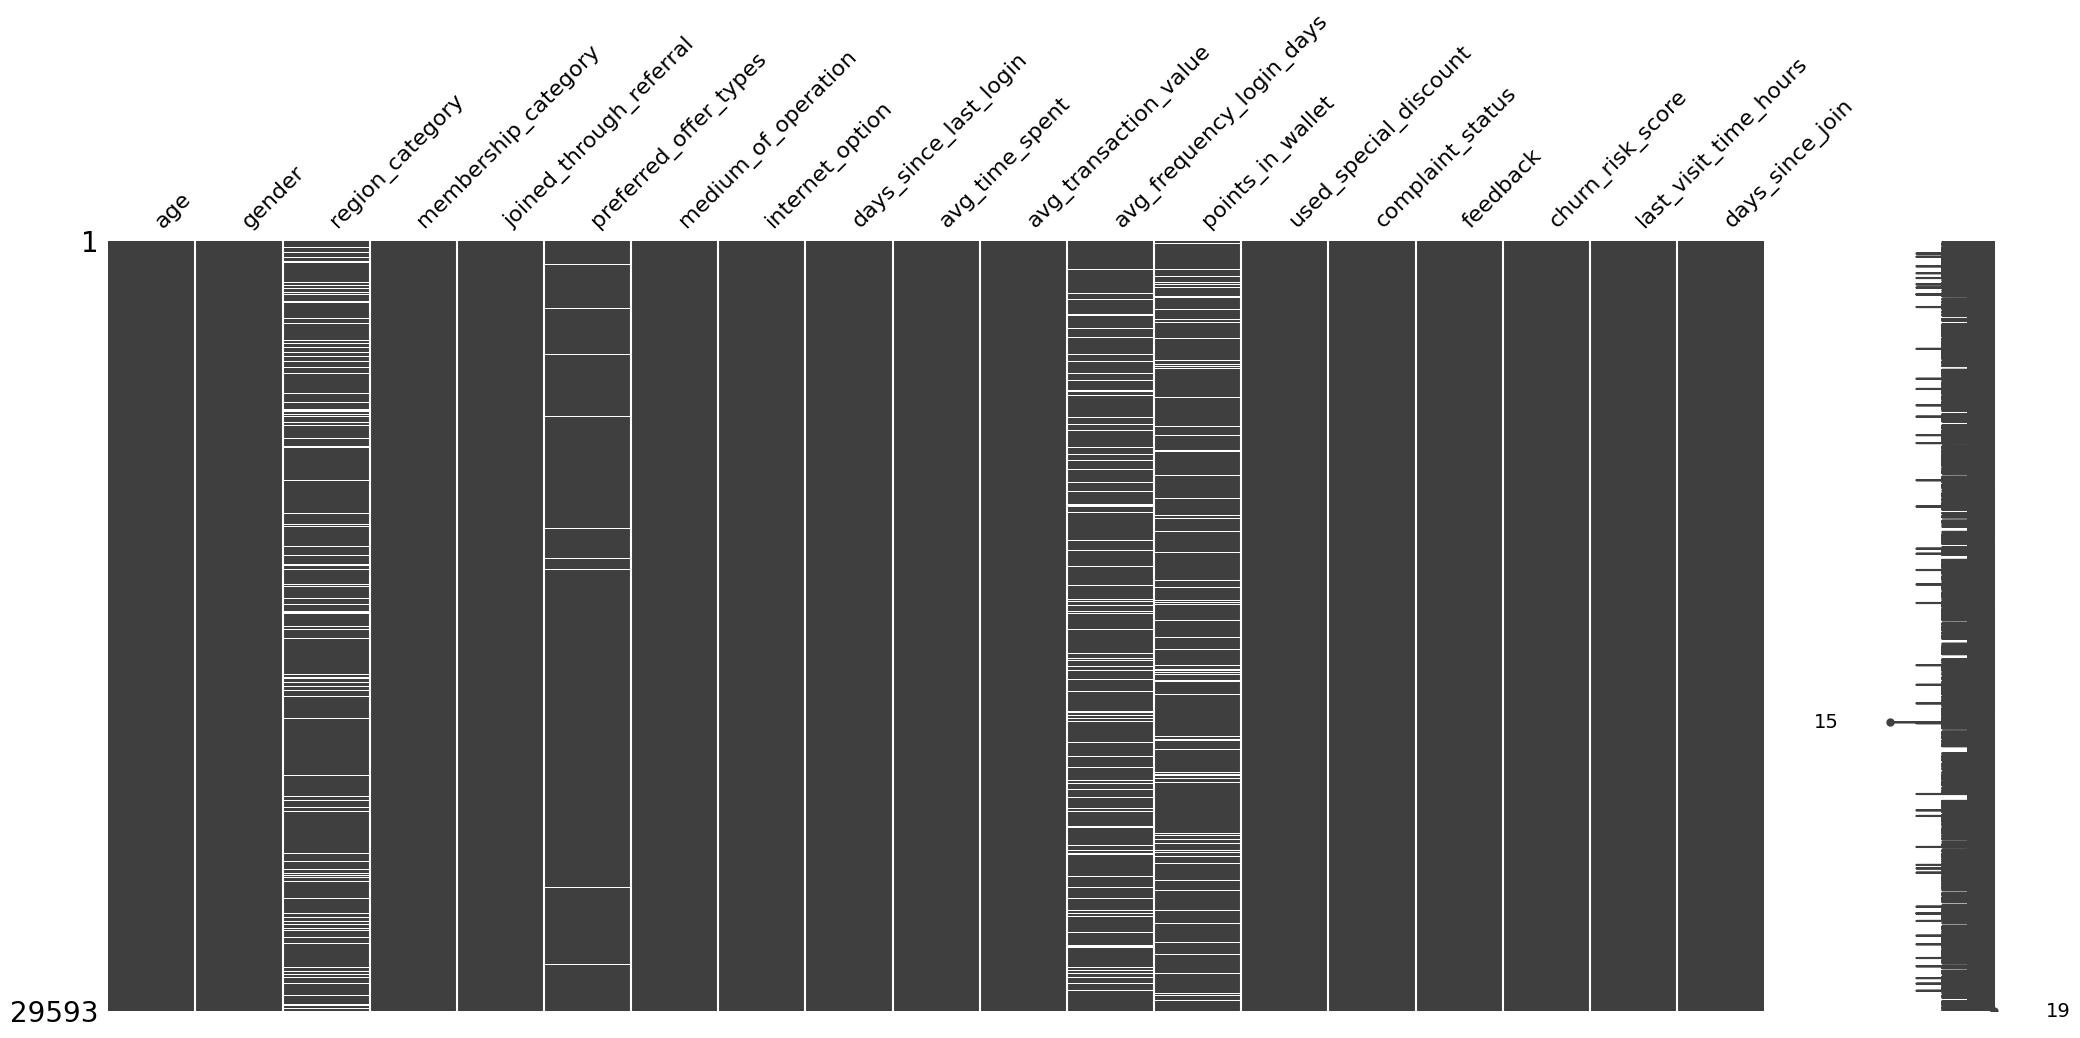

In [84]:
# Use missingno to look for a pattern in missing values. 
msno.matrix(df_train, width_ratios=(8, 1))

We don`t see a systematic pattern of missing values. Now lets check how many rows have more than one missing value:

In [85]:
import pandas as pd

# Missing values per row
missing_values_per_row = df_train.isnull().sum(axis=1)

# count how many rows have 1,2,3 or 4 missing values
missing_values_counts = missing_values_per_row.value_counts().sort_index()

print(missing_values_counts)


0    20568
1     7998
2      980
3       46
4        1
Name: count, dtype: int64


<Axes: >

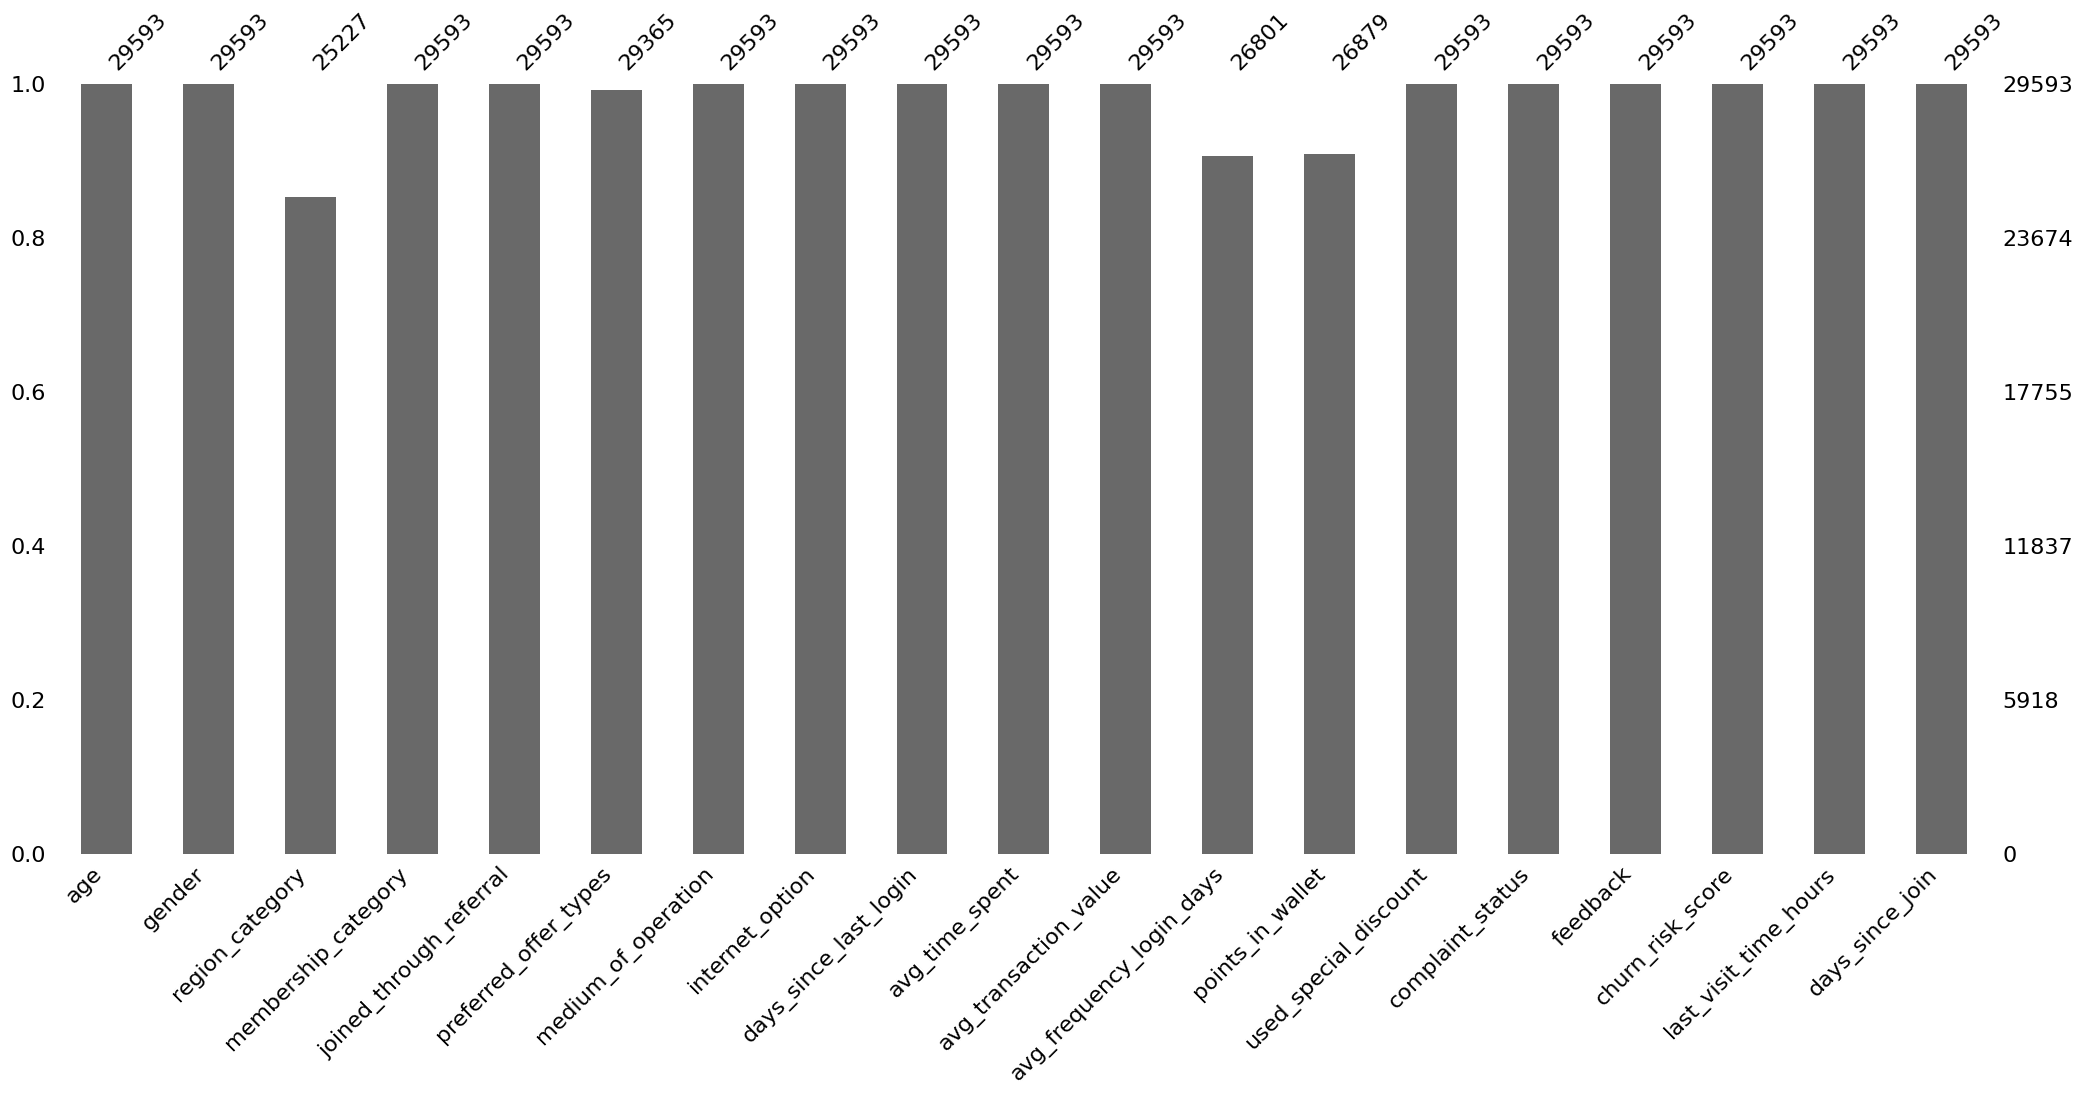

In [86]:
# Look for msssing values in relativ and absolute numbers
msno.bar(df_train)

<Axes: >

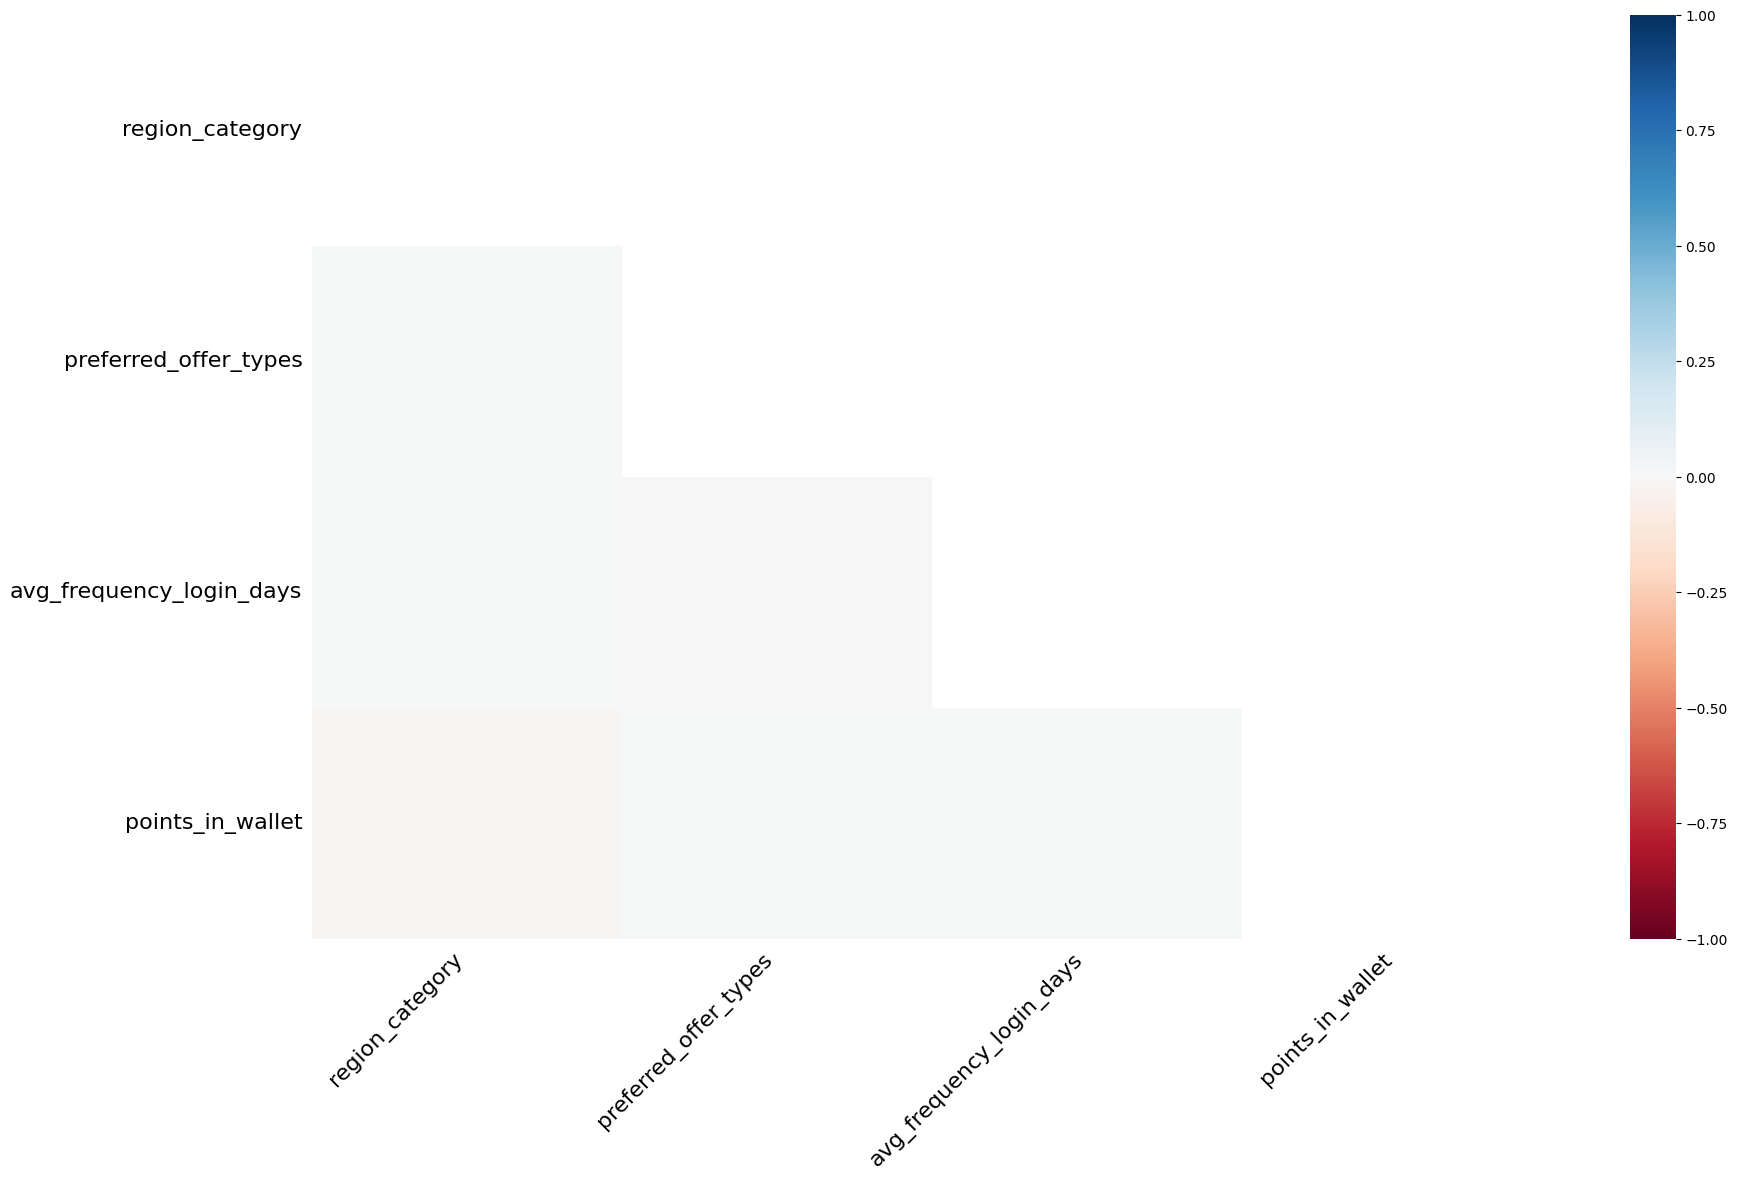

In [87]:
msno.heatmap(df_train)

[The missingno correlation heatmap measures nullity correlation](https://github.com/ResidentMario/missingno): how strongly the presence or absence of one variable affects the presence of another."   
   
All the variables with missing values don`t show any correlation among each other. This confirms our assumption from the matrix.  
    
**We don't drop complete rows with NaN. We look for the NaN at the features in detail.**




### Drop 'days_since_last_login' with value -999 

In [88]:
# Drop 'days_since_last_login' with value -999 
df_train = df_train[df_train.days_since_last_login != -999]
df_test = df_test[df_test.days_since_last_login != -999]

### Handling nan values in 'region_category' and 'preferred_offer_types'

In [89]:
# Region category includes many unknown values// impute by neutral category "Unknown"
df_train.region_category = df_train.region_category.astype("object")
df_train.region_category.fillna("Unknown", inplace= True)
df_train.region_category = df_train.region_category.astype("category")

df_test.region_category = df_test.region_category.astype("object")
df_test.region_category.fillna("Unknown", inplace = True)
df_test.region_category = df_test.region_category.astype("category")

#preferred offer types// drop nan because too few// avoid extreme minority class if imputing
df_train.dropna(subset= ["preferred_offer_types"], inplace= True)
df_test.dropna(subset= ["preferred_offer_types"], inplace= True)

### Handling of missing numerical values

In [92]:
#impute numerical values by mean value
avg_frequency_login_days_mean = df_train.avg_frequency_login_days.mean()
print(f"Mean of 'avg_frequency_login_days_mean: {avg_frequency_login_days_mean}")
df_train.avg_frequency_login_days.fillna(avg_frequency_login_days_mean, inplace = True)

points_in_wallet_mean = df_test.points_in_wallet.mean()
print(f"Mean of 'points_in_wallet: {points_in_wallet_mean}")
df_train.points_in_wallet.fillna(points_in_wallet_mean, inplace = True)

#!!! impute test data with mean from train data!!!
df_test.avg_frequency_login_days.fillna(avg_frequency_login_days_mean, inplace = True)
df_test.points_in_wallet.fillna(points_in_wallet_mean, inplace = True)



Mean of 'avg_frequency_login_days_mean: 16.000797271728516
Mean of 'points_in_wallet: 686.0516306556567


### Check if all NaN are removed

In [57]:
df_test.isna().sum()

age                         0
gender                      0
region_category             0
membership_category         0
joined_through_referral     0
preferred_offer_types       0
medium_of_operation         0
internet_option             0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
used_special_discount       0
complaint_status            0
feedback                    0
churn_risk_score            0
last_visit_time_hours       0
days_since_join             0
dtype: int64

## Renaming some values
For aesthetic reasons we rename values of 'joined_through_refferal' from "?" to "Unknown"

In [ ]:
# Change "?" to "Unknown"
df_train.joined_through_referral[df_train.joined_through_referral == "?"] = "Unknown"
df_test.joined_through_referral[df_test.joined_through_referral == "?"] = "Unknown"
df_train.joined_through_referral.unique()

### Export DataFrame before One-Hot-Encoding for models which work without

In [58]:
# export before one-hot-encoding - for model like KNN and SVM
df_train.to_pickle('./data/df_train_KNN.pkl')
df_test.to_pickle('./data/df_test_KNN.pkl')

# Encoding

In [59]:
#one hot encode
to_ohe = ["gender",
          "region_category",
          "joined_through_referral",
          "preferred_offer_types", 
          "medium_of_operation", 
          "internet_option", 
          "used_special_discount", 
          "complaint_status", 
          "feedback"]

#column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop= "first", handle_unknown='ignore'), to_ohe)
    ],
    remainder='passthrough'  # Keep any remaining columns unchanged
)


# Fit and transform the data
data_encoded = preprocessor.fit_transform(df_train)
data_encoded_test = preprocessor.transform(df_test)

# Get column names for the one-hot encoded columns
column_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(to_ohe)

# Create a DataFrame with the one-hot encoded columns
df_train = pd.DataFrame(data_encoded, columns=list(column_names) + list(df_train.columns.drop(to_ohe)))
df_test = pd.DataFrame(data_encoded_test, columns=list(column_names) + list(df_test.columns.drop(to_ohe)))


Ordinal Scaling of ordinal category 'membership_category'   
Based on the assumption of the plot of the EDA.

In [60]:
# Order of category we assumed
order = { "No Membership": 0,
         "Basic Membership": 1,
         "Silver Membership": 2,
         "Gold Membership": 3,
         "Platinum Membership": 4,
         "Premium Membership": 5}
# Ordinal encoding
df_train.membership_category = df_train.membership_category.map(order)
df_test.membership_category = df_test.membership_category.map(order)

Export encoded DataFrame 

In [61]:
# export before scaling - for Decision Tree
df_train.to_pickle('./data/df_train_dt.pkl')
df_test.to_pickle('./data/df_test_dt.pkl')

# Scaling

In [62]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27770 entries, 0 to 27769
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   gender_M                                     27770 non-null  object
 1   gender_Unknown                               27770 non-null  object
 2   region_category_Town                         27770 non-null  object
 3   region_category_Unknown                      27770 non-null  object
 4   region_category_Village                      27770 non-null  object
 5   joined_through_referral_Unknown              27770 non-null  object
 6   joined_through_referral_Yes                  27770 non-null  object
 7   preferred_offer_types_Gift Vouchers/Coupons  27770 non-null  object
 8   preferred_offer_types_Without Offers         27770 non-null  object
 9   medium_of_operation_Both                     27770 non-null  object
 10  medium_of_

Since we will train model based on Logistic Regression we use Standard Scaler.
It will improve the convergence of optimization algorithms and it ensures the regularization is applied uniformly across features. 

In [94]:
num_features = ["age", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", "points_in_wallet", "last_visit_time_hours", "days_since_join"]

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features)  # Scale selected columns
    ],
    remainder='passthrough'  # Keep any remaining columns unchanged
)

# Fit and transform the data
data_scaled = preprocessor.fit_transform(df_train)
data_scaled_test = preprocessor.transform(df_test)

# Convert the transformed data back to a DataFrame
df_train = pd.DataFrame(data_scaled, columns=num_features + list(df_train.columns.drop(num_features)))
df_test = pd.DataFrame(data_scaled_test, columns=num_features + list(df_test.columns.drop(num_features)))

Check result of scaling (mean must be 0, standard deviation must be 1)

In [97]:
print("mean of scaled numerical values:")
print(df_train[num_features].mean())
print()
print("standard deviation of scaled numerical values:")
print(df_train[num_features].std())

mean of scaled numerical values:
age                         0.0
avg_time_spent              0.0
avg_transaction_value       0.0
avg_frequency_login_days    0.0
points_in_wallet            0.0
last_visit_time_hours       0.0
days_since_join             0.0
dtype: object

standard deviation of scaled numerical values:
age                         1.000018
avg_time_spent              1.000018
avg_transaction_value       1.000018
avg_frequency_login_days    1.000018
points_in_wallet            1.000018
last_visit_time_hours       1.000018
days_since_join             1.000018
dtype: object


Export the final DataFrame

In [65]:
df_train.to_pickle('./data/df_train.pkl')
df_test.to_pickle('./data/df_test.pkl')